In [1]:
########## import packages ##########

import pandas as pd
import numpy as np
from scipy import stats
from sklearn.linear_model import LassoLarsIC, LinearRegression, LassoCV, LassoLarsCV
from sklearn import preprocessing
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
########## functions from python file ##########

# inputs: excess returns dataframe, method, start row and end row number (inclusive rows), and mode
# output: predicted values and coefficients (or intercepts and coefficients)
# runs ols post lasso regression on the data and returns predicted value on the next time period
def OLSlassoRegression(df, method="aic", startRow = 0, endRow = 684, mode="fit"): 
    indNames = list(df.iloc[:, 1:])
    #dataframes to contain betas and predicted values
    lassoResults = pd.DataFrame(np.zeros((len(indNames), len(indNames))), columns = indNames, index = indNames)
    intercepts = pd.DataFrame(np.zeros(len(indNames)), columns = ["Intercept"])
    out = pd.DataFrame(np.zeros(len(indNames)), columns = ["yPred"], index = indNames)
    dfSliced = df.iloc[startRow:endRow + 1, 1:] # no date
    for indIndex in range(len(indNames)):
        X = dfSliced.iloc[:-1, :] 
        y = dfSliced.iloc[1:, indIndex] 
        lasso = lassoM(X, y, method)
        xIndex = np.nonzero(lasso.coef_)[0]
        Xlin = X[X.columns[xIndex]]
        if len(xIndex) > 0:
            ols = linearM(Xlin, y)
            j = 0
            intercepts.iloc[indIndex, 0] = ols.intercept_
            for i in xIndex:
                lassoResults.iloc[indIndex, i] = ols.coef_[j]
                j += 1
            if mode == "predict":
                Xnew = [df.iloc[endRow, xIndex + 1]] # shift selected predictors by 1 columns (date)
                out.iloc[indIndex, 0] = ols.predict(Xnew)[0]
        # no x variables selected, then change later to mean of cross section returns
        else: 
            out.iloc[indIndex, 0] = np.nan
    return (out, lassoResults) if mode == "predict" else (intercepts, lassoResults)

# inputs: excess returns dataframe, method, start row and end row number (inclusive rows), and mode
# output: predicted values and coefficients (or intercepts and coefficients)
# runs ols regression on the data and returns predicted value on the next time period
def OLSRegression(df, method="aic", startRow = 0, endRow = 684, mode="fit"):
    indNames = list(df.iloc[:, 1:])
    #dataframes to contain betas and predicted values
    betas = pd.DataFrame(np.zeros((len(indNames), len(indNames))), columns = indNames, index = indNames)
    intercepts = pd.DataFrame(np.zeros(len(indNames)), columns = ["Intercept"])
    out = pd.DataFrame(np.zeros(len(indNames)), columns = ["yPred"], index = indNames)
    dfSliced = df.iloc[startRow:endRow + 1, 1:] # no date

    for indIndex in range(len(indNames)):
        X = dfSliced.iloc[:-1, :] 
        y = dfSliced.iloc[1:, indIndex] 
        ols = linearM(X, y)
        j = 0
        intercepts.iloc[indIndex, 0] = ols.intercept_
        for i in range(len(indNames)):
            betas.iloc[indIndex, i] = ols.coef_[j]
            j += 1
        if mode == "predict":
            Xnew = [df.iloc[endRow, 1:]] # shift selected predictors by 1 columns (date)
            out.iloc[indIndex, 0] = ols.predict(Xnew)[0]
    return (out, betas) if mode == "predict" else (intercepts, betas)

# inputs: paths to industry returns and risk free rate, beginning date and end date
# output: industry and risk free dataframes (in percentages)
# loads data
def loadData(indPath, rfPath, begDate, endDate):
    #read in data
    ind = pd.read_csv(indPath, skiprows = 11)
    rf = pd.read_csv(rfPath)
    rf.dateff = rf.dateff // 100
    #rename column
    ind.rename(columns={'Unnamed: 0':'Date'}, inplace=True )
    #only select certain dates 
    rf = rf.loc[(rf["dateff"] >= int(begDate)) & (rf["dateff"] <= int(endDate))]
    startRow = (ind[ind.Date == begDate].index)[0]
    endRow = (ind[ind.Date == endDate].index)[0]
    ind = ind.iloc[startRow:endRow + 1]
    ind = ind.reset_index(drop=True)
    rf = rf.reset_index(drop=True)
    indNames = list(ind)
    #convert returns to float and year to int
    ind[indNames[1:]] = ind[indNames[1:]].astype(float)

    ind[indNames[0]] = ind[indNames[0]].astype(int)
    rf["rf"] = rf["rf"] * 100 #all returns in percentages
    return (ind, rf)

# inputs: industry returns and risk free rate dataframes
# output: excess returns dataframe 
# calculates excess returns from raw data
def excessReturns(ind, rf):
    exsReturns = ind.copy()
    indNames = list(ind)
    for i in range(1, len(indNames)):
        exsReturns.iloc[:, i] = ind.iloc[:, i] - rf.iloc[:, 1]
    return exsReturns

# input: excess returns dataframe
# output: dataframe containing summary statistics
# creates summary statistics table (table 1 in research paper)
def summaryStat(exsReturns):
    #create new dataframe to hold summary statistics
    resNames = ["Ann mean", "Ann vol", "Minimum", "Maximum", "Ann Sharpe"]
    res = pd.DataFrame(columns = resNames)
    #ann mean, vol, min, max, sharpe
    res.iloc[:, 0] = np.mean(exsReturns, axis=0) * 12
    res.iloc[:, 1] = (np.std(exsReturns, axis=0) * (12 ** 0.5))
    res.iloc[:, 2] = np.amin(exsReturns, axis=0)
    res.iloc[:, 3] = np.amax(exsReturns, axis=0)
    res.iloc[:, 4] = res.iloc[:, 0] / res.iloc[:, 1]
    return res

# input: X and y values, and method
# output: lasso object
def lassoM(X, y, method):
    if (method == "aic") or (method == "bic"):
        lasso = LassoLarsIC(criterion = method, normalize = True)
        lasso.fit(X, y)
    elif method == "LassoCV": 
        lasso = LassoCV(cv = 20).fit(X, y)
    elif method == "LassoLarsCV": 
        lasso = LassoLarsCV(cv = 20).fit(X, y)
    return lasso

# input: X and y values
# output: linear regression object
def linearM(X, y):
    lin = LinearRegression()
    lin.fit(X, y)
    return lin

In [3]:
########## read in data ##########

indPath = "30_Industry_Portfolios.CSV"
rfPath = "rf.csv"
begDate = "195912"
endDate = "201612"
(ind, rf) = loadData(indPath, rfPath, begDate, endDate)
exsReturns = excessReturns(ind, rf) 
nrow = rf.count()[0]

#create summary table (table 1 in paper)
sumTable = summaryStat(exsReturns.iloc[:, 1:]) # no date
print(sumTable)

        Ann mean    Ann vol  Minimum  Maximum  Ann Sharpe
Food    8.288584  15.022567   -18.15    19.89    0.551742
Beer    8.527358  17.620146   -20.19    25.51    0.483955
Smoke  11.787854  20.982604   -25.32    32.38    0.561792
Games   8.420496  24.857267   -33.40    34.52    0.338754
Books   6.339328  20.109360   -26.56    33.13    0.315243
Hshld   6.650277  16.476647   -22.24    18.22    0.403618
Clths   8.033518  22.105695   -31.50    31.79    0.363414
Hlth    7.810861  17.058878   -21.06    29.01    0.457877
Chems   6.237372  19.102606   -28.60    21.68    0.326519
Txtls   8.008993  24.309069   -33.11    59.03    0.329465
Cnstr   6.281518  20.739503   -28.74    25.02    0.302877
Steel   3.543591  25.254249   -32.99    30.36    0.140317
FabPr   6.751007  21.164538   -31.63    22.91    0.318977
ElcEq   8.450628  21.501609   -32.80    23.21    0.393023
Autos   5.447825  23.154738   -36.49    49.56    0.235279
Carry   8.624759  21.783186   -31.10    23.39    0.395937
Mines   6.5838

In [4]:
########## OLS post Lasso with entire time period ##########

indNames = list(exsReturns.iloc[:, 1:])
df = exsReturns
(inter, fullPeriodResult)= OLSlassoRegression(df) # use aic

In [5]:
########## expanding period L/S portfolio construction ##########

startRow = 0
endRow = df.loc[df["Date"] == 196912].index[0] #start before the first prediction date (paper uses 196912)
lastRow = df.loc[df["Date"] == 201612].index[0]

# start with first predicting row
dateIndex = pd.period_range(start = pd.Period(str(df.loc[endRow + 1, "Date"]), freq = "M"), 
                            end = pd.Period(str(df.loc[lastRow, "Date"]), freq = "M"), freq = "M") 

# dataframes to contain return for each time period for ols post lasso, ols, and prevailing mean
periodR = pd.DataFrame(np.zeros(lastRow - endRow), columns = ["r"], index = dateIndex)
periodRLin = pd.DataFrame(np.zeros(lastRow - endRow), columns = ["r"], index = dateIndex)
periodRPM = pd.DataFrame(np.zeros(lastRow - endRow), columns = ["r"], index = dateIndex)

indBeta = pd.DataFrame(np.zeros((lastRow - endRow, len(indNames))), index = dateIndex, columns = indNames) 
ind = 0 # food

for e in range(endRow, lastRow):
    #OLS POST LASSO OUTPUTS
    (yPred, betas) = OLSlassoRegression(df, startRow = startRow, endRow = e, mode="predict")

    # change not predicted returns to mean of cross section returns
    yPred.loc[np.isnan(yPred)["yPred"], :] = np.nanmean(yPred, axis = 0)
    yPred.sort_values(by = ["yPred"], ascending = True, inplace = True)
    bottomInd = yPred.iloc[:6, :].index #find the industries
    topInd = yPred.iloc[-6:, :].index
    bottomR = df.loc[e + 1, bottomInd] #get the realized returns
    topR = df.loc[e + 1, topInd]
    
    print(indBeta.index[e - endRow], np.round(np.average(topR), 2), np.round(np.average(bottomR), 2), np.round(np.average(topR) - np.average(bottomR), 2))
    periodR.iloc[e - endRow, :] = np.mean(topR) - np.mean(bottomR)
    indBeta.iloc[e - endRow, :] = betas.loc[betas.index[ind], :]
    
    #LINEAR MODEL OUTPUTS
    (yPredLin, betasLin) = OLSRegression(df, startRow = startRow, endRow = e, mode="predict")
    yPredLin.sort_values(by = ["yPred"], ascending = True, inplace = True)
    bottomIndLin = yPredLin.iloc[:6, :].index #find the industries
    topIndLin = yPredLin.iloc[-6:, :].index
    bottomRLin = df.loc[e + 1, bottomIndLin] #get the realized returns
    topRLin = df.loc[e + 1, topIndLin]
    periodRLin.iloc[e - endRow, :] = np.mean(topRLin) - np.mean(bottomRLin)
    
    #PREVAILING MEAN OUPUTS
    X = df.iloc[startRow:e + 1, 1:]
    yPredPM = np.mean(X, axis = 0)
    yPredPM.sort_values(ascending = True, inplace = True)
    bottomIndPM = yPredPM[:6].index #find the industries
    topIndPM = yPredLin.iloc[-6:, :].index
    bottomRPM = df.loc[e + 1, bottomIndPM] #get the realized returns
    topRPM = df.loc[e + 1, topIndPM]
    periodRPM.iloc[e - endRow, :] = np.mean(topRPM) - np.mean(bottomRPM)


1970-01 -6.31 -8.12 1.81
1970-02 6.88 5.58 1.3
1970-03 -3.28 -0.9 -2.38
1970-04 -12.53 -14.53 2.0
1970-05 -7.82 -11.62 3.79
1970-06 -4.95 -8.53 3.58
1970-07 5.83 7.27 -1.44
1970-08 5.65 3.64 2.0
1970-09 11.97 4.88 7.09
1970-10 -5.94 -4.27 -1.66
1970-11 4.69 1.42 3.27
1970-12 8.23 6.5 1.72
1971-01 8.97 5.58 3.39
1971-02 3.36 3.18 0.18
1971-03 6.6 2.65 3.95
1971-04 4.05 4.68 -0.62
1971-05 -3.81 -2.42 -1.4
1971-06 -1.0 -0.23 -0.77
1971-07 -3.26 -7.4 4.14
1971-08 5.78 4.59 1.19
1971-09 -0.51 -2.38 1.87
1971-10 -4.73 -6.89 2.16
1971-11 -0.28 -2.28 1.99
1971-12 10.27 12.72 -2.45
1972-01 6.46 2.02 4.44
1972-02 4.03 2.38 1.65
1972-03 0.85 1.2 -0.34
1972-04 1.18 1.32 -0.14
1972-05 2.08 0.09 1.99
1972-06 -2.67 -2.94 0.28
1972-07 -1.24 -4.17 2.93
1972-08 2.45 -1.1 3.55
1972-09 -3.22 -0.96 -2.26
1972-10 -0.81 -1.56 0.75
1972-11 3.93 8.17 -4.25
1972-12 -1.9 -0.65 -1.25
1973-01 -3.17 -7.0 3.83
1973-02 -2.28 -8.92 6.64
1973-03 0.4 -2.26 2.66
1973-04 -6.99 -5.41 -1.58
1973-05 -1.5 -6.72 5.21
1973-06 -

1998-07 -3.63 -4.96 1.33
1998-08 -13.13 -20.16 7.03
1998-09 4.95 8.94 -3.99
1998-10 7.26 9.58 -2.31
1998-11 6.63 4.0 2.64
1998-12 4.41 2.49 1.92
1999-01 1.48 2.44 -0.96
1999-02 -1.96 -3.35 1.4
1999-03 4.62 0.21 4.42
1999-04 12.59 12.75 -0.16
1999-05 -3.52 -0.45 -3.07
1999-06 1.87 0.61 1.27
1999-07 -5.56 -1.43 -4.13
1999-08 -1.18 -5.03 3.85
1999-09 -6.18 -4.96 -1.21
1999-10 6.97 -1.47 8.44
1999-11 -0.59 -0.44 -0.15
1999-12 2.16 11.19 -9.03
2000-01 5.36 -5.44 10.8
2000-02 1.53 -6.5 8.03
2000-03 4.25 14.12 -9.86
2000-04 2.09 0.83 1.27
2000-05 3.42 -7.4 10.82
2000-06 -1.45 3.99 -5.44
2000-07 0.49 0.37 0.12
2000-08 6.5 6.91 -0.41
2000-09 -2.79 -2.17 -0.62
2000-10 1.84 -2.01 3.85
2000-11 -5.6 -5.54 -0.06
2000-12 3.96 5.82 -1.86
2001-01 -2.3 6.15 -8.45
2001-02 -5.34 -4.83 -0.51
2001-03 -6.88 -5.02 -1.86
2001-04 7.34 4.06 3.28
2001-05 0.95 1.25 -0.3
2001-06 -1.82 -4.8 2.98
2001-07 -0.47 -3.24 2.77
2001-08 1.84 -5.13 6.97
2001-09 -7.46 -10.73 3.28
2001-10 3.92 6.03 -2.11
2001-11 2.53 5.21 -2.67

In [6]:
########## calculate performance for each portfolio constructions ##########

perfMean = np.mean(periodR["r"]) * 12
perfVol = np.std(periodR["r"]) * (12 ** 0.5)

perfMeanLin = np.mean(periodRLin["r"]) * 12
perfVolLin = np.std(periodRLin["r"]) * (12 ** 0.5)

perfMeanPM = np.mean(periodRPM["r"]) * 12
perfVolPM = np.std(periodRPM["r"]) * (12 ** 0.5)
print("Ann Mean = ", perfMean, perfMeanLin, perfMeanPM)
print("Ann Vol = ", perfVol, perfVolLin, perfVolPM)

Ann Mean =  6.403156028368795 5.70400709219858 1.5759574468085098
Ann Vol =  11.025178675735628 11.63957777692365 8.966325954392717


<Figure size 1440x720 with 0 Axes>

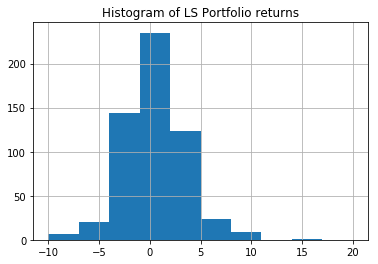

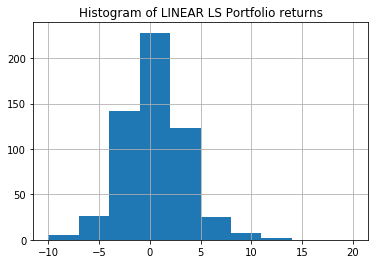

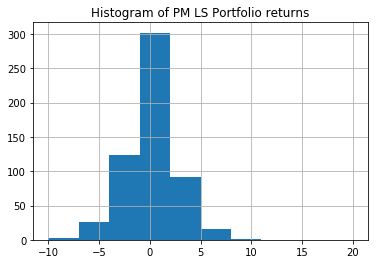

In [7]:
########## plot histogram of realized portfolio returns ##########

plt.figure(figsize=(20,10))
periodR.hist(range = (-10, 20))
plt.title("Histogram of LS Portfolio returns")
plt.show()

periodRLin.hist(range = (-10, 20))
plt.title("Histogram of LINEAR LS Portfolio returns")

periodRPM.hist(range = (-10, 20))
plt.title("Histogram of PM LS Portfolio returns")
plt.show()

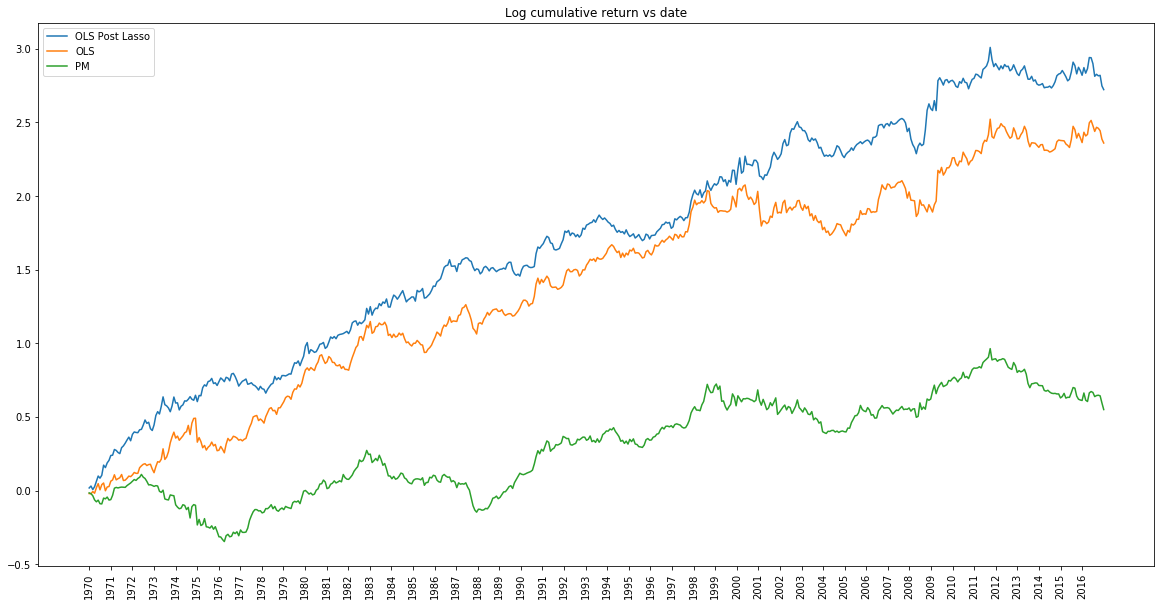

In [8]:
########## plot log cumulative return (figure 3 in paper) ##########
plt.figure(figsize = (20,10))
t = np.linspace(0, len(periodR["r"]), len(periodR["r"]))

logcumR = np.log((1 + periodR["r"]/100).cumprod()) 
plt.plot(t, logcumR, label = "OLS Post Lasso")

logcumRLin = np.log((1 + periodRLin["r"]/100).cumprod()) 
plt.plot(t, logcumRLin, label = "OLS")

logcumRPM = np.log((1 + periodRPM["r"]/100).cumprod()) 
plt.plot(t, logcumRPM, label = "PM")

plt.title("Log cumulative return vs date")
plt.legend()
x = periodR.index
plt.xticks(np.arange(len(x), step=12), x.asfreq("A").unique(), rotation = "vertical")
plt.show()



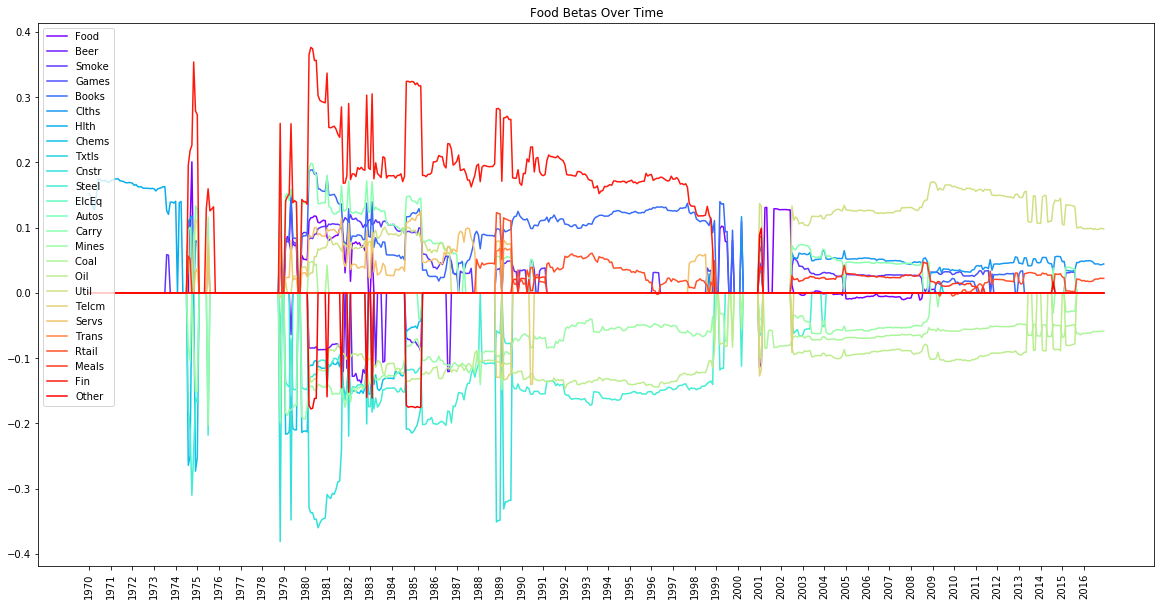

In [9]:
########## plot betas for food industry ########## 

plt.figure(figsize=(20,10))
(x, y) = indBeta.index, indBeta
xlab = "Date"
ylab = "OLS post Lasso Coefficiets"
title = indNames[ind] + "Betas Over Time"
xnew = range(len(x)) # equally spaced
colors = cm.rainbow(np.linspace(0, 1, len(list(y))))
for i in range(len(list(y))):
    if (len(np.nonzero(y.iloc[:, i])[0]) == 0): # industry not used at all
        plt.plot(xnew, y.iloc[:, i], label = "_nolegend_", color = colors[i])
    else:
        plt.plot(xnew, y.iloc[:, i], label = list(y)[i], color= colors[i])
plt.legend(fontsize = "medium", loc=2)

plt.title(title)
plt.xticks(np.arange(len(x), step=12), x.asfreq("A").unique(), rotation = "vertical")
plt.show()

NameError: name 'allIndPred' is not defined

<Figure size 1440x720 with 0 Axes>

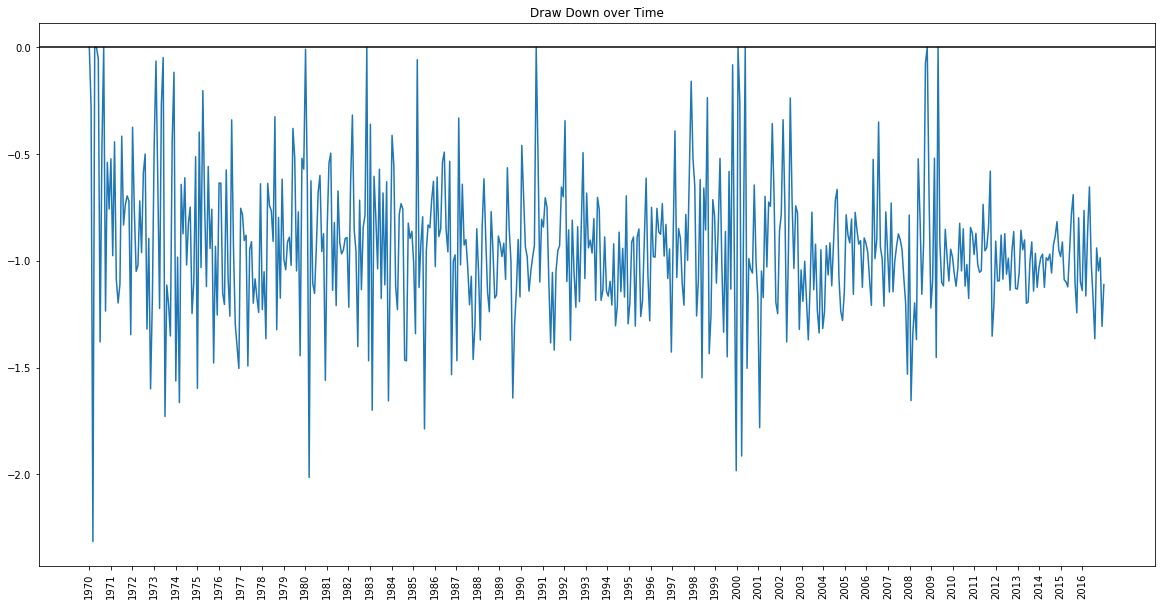

-2.314285714285715


In [67]:
########## Maximum Drawdown ########## 

# R = periodR.iloc[:, 0]

# maxR = R[0]
# DD = []
# for r in R:
#     DD.append(min((r - maxR) / maxR, 0))
#     #print(maxR)
#     if r > maxR:
#         maxR = r
        
maximums = np.maximum.accumulate(periodR["r"])
DD = periodR["r"] / maximums - 1


plt.figure(figsize = (20,10))
t = np.linspace(0, len(DD), len(DD))
plt.plot(t, DD, label = "DD")

plt.title("Draw Down over Time")
x = periodR.index
plt.xticks(np.arange(len(x), step=12), x.asfreq("A").unique(), rotation = "vertical")

plt.axhline(y=0, color='black', linestyle='-')


plt.show()

print(min(DD))



In [66]:
maximums = np.maximum.accumulate(periodR["r"])
print(np.min(periodR["r"] / maximums - 1))

maximums = np.maximum.accumulate(periodRLin["r"])
print(np.min(periodRLin["r"] / maximums - 1))

maximums = np.maximum.accumulate(periodRPM["r"])
print(np.min(periodRPM["r"] / maximums - 1))

-2.314285714285715
-2.867344820427651
-3.0898550724637683
